In [61]:
import clip
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn.functional as F
import transformers

from PIL import Image
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity
from transformers import CLIPProcessor, CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
with open("./data/german_metaphor_prompts_in_german.txt", "r") as file:
    german_prompts = [line.strip().replace(".", "") for line in file.readlines()]
with open("./data/english_metaphor_prompts.txt", "r") as file:
    english_prompts = [line.strip().replace(".", "") for line in file.readlines()]

In [5]:
df = pd.DataFrame({
    "german_prompts": german_prompts, 
    "english_prompts": english_prompts
})

In [6]:
# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [7]:
def generate_ouput(model, text, image):
    url = "http://images.cocodataset.org/val2017/000000039769.jpg"
    image = Image.open(requests.get(url, stream=True).raw)
    
    inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)
    
    return model(**inputs)

In [8]:
def get_text_embeddings(text_file, model):
    with open(text_file, "r") as file:
        data = [line.strip().replace(".", "") for line in file.readlines()]
    inputs = processor(text=data, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        embeddings = model.get_text_features(**inputs)
    return embeddings

def get_image_embeddings(folder, model):
    image_series = [Image.open(image) for image in Path(folder).glob("*.*")]
    inputs = processor(images=image_series, return_tensors="pt")
    with torch.no_grad():
        embeddings = model.get_image_features(**inputs)
    return embeddings

def get_cosine_similarity(array1, array2):
    return F.cosine_similarity(array1, array2)

In [9]:
folder_path = Path(r"./images")
relevant_folders_path = [folder for folder in folder_path.rglob("*") if folder.is_dir() and folder.name not in ["german", "english"] and "prompt" not in folder.name and "baseline" not in folder.parts]
relevant_folders_name = [f"{folder.name}_{folder.parent.name}_{folder.parent.parent.name}" for folder in relevant_folders_path]

In [11]:
english_short_prompts = r"./data/english_metaphors.txt"
english_long_prompts = r"./data/english_metaphor_prompts.txt"
german_short_prompts = r"./data/german_metaphors.txt"
german_long_prompts = r"./data/german_metaphor_prompts_in_german.txt"

all_text_embeddings = {
    "english_short_prompt": get_text_embeddings(english_short_prompts, model),
    "english_long_prompt": get_text_embeddings(english_long_prompts, model),
    "german_short_prompt": get_text_embeddings(german_short_prompts, model),
    "german_long_prompt": get_text_embeddings(german_long_prompts, model),
}

In [12]:
all_image_embeddings = {}
for folder in relevant_folders_path:
    key = f"{folder.name}_{folder.parent.name}_{folder.parent.parent.name}"
    all_image_embeddings[key] = get_image_embeddings(folder, model)

In [13]:
with open("./output/base_clip_text_embeddings.pickle", "wb") as file:
    pickle.dump(all_text_embeddings, file)
with open("./output/base_clip_image_embeddings.pickle", "wb") as file:
    pickle.dump(all_image_embeddings, file)
    
with open("./output/base_clip_text_embeddings.pickle", "rb") as file:
    all_text_embeddings = pickle.load(file)
with open("./output/base_clip_image_embeddings.pickle", "rb") as file:
    all_image_embeddings = pickle.load(file)

C:\Users\phanm\miniconda3\envs\ml\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [14]:
long_prompts_text_image = {
    "G-GPT": get_cosine_similarity(all_text_embeddings["german_long_prompt"], all_image_embeddings["chatgpt_german_long_prompts"]).mean().numpy(),
    "G-1.5": get_cosine_similarity(all_text_embeddings["german_long_prompt"], all_image_embeddings["sd1.5_german_long_prompts"]).mean().numpy(),
    "G-XL": get_cosine_similarity(all_text_embeddings["german_long_prompt"], all_image_embeddings["sdxl_german_long_prompts"]).mean().numpy(),
    "G-CC": get_cosine_similarity(all_text_embeddings["german_long_prompt"], all_image_embeddings["sdcc_german_long_prompts"]).mean().numpy(),
    "E-GPT": get_cosine_similarity(all_text_embeddings["english_long_prompt"], all_image_embeddings["chatgpt_english_long_prompts"]).mean().numpy(),
    "E-1.5": get_cosine_similarity(all_text_embeddings["english_long_prompt"], all_image_embeddings["sd1.5_english_long_prompts"]).mean().numpy(),
    "E-XL": get_cosine_similarity(all_text_embeddings["english_long_prompt"], all_image_embeddings["sdxl_english_long_prompts"]).mean().numpy(),
    "E-CC": get_cosine_similarity(all_text_embeddings["english_long_prompt"], all_image_embeddings["sdcc_english_long_prompts"]).mean().numpy(),
}
long_prompts_text_image

{'G-GPT': array(0.25405148, dtype=float32),
 'G-1.5': array(0.24312702, dtype=float32),
 'G-XL': array(0.2515412, dtype=float32),
 'G-CC': array(0.25986102, dtype=float32),
 'E-GPT': array(0.3139544, dtype=float32),
 'E-1.5': array(0.28107557, dtype=float32),
 'E-XL': array(0.3178013, dtype=float32),
 'E-CC': array(0.31023827, dtype=float32)}

In [69]:
rows = ["English", "German"]
columns = ["GPT", "1.5", "XL", "CC"]

# Initialize an empty DataFrame with the correct row and column names
df_long = pd.DataFrame(index=rows, columns=columns)

# Fill the DataFrame with values from the dictionary
for key, value in long_prompts_text_image.items():
    row, col = key.split("-")
    row = "English" if row == "E" else "German"
    df_long.at[row, col] = value

df_long

,GPT,1.5,XL,CC
English,0.3139544,0.28107557,0.3178013,0.31023827
German,0.25405148,0.24312702,0.2515412,0.25986102


In [54]:
short_prompts_text_image = {
    "G-GPT": get_cosine_similarity(all_text_embeddings["german_short_prompt"], all_image_embeddings["chatgpt_german_short_prompts"]).mean().numpy(),
    "G-1.5": get_cosine_similarity(all_text_embeddings["german_short_prompt"], all_image_embeddings["sd1.5_german_short_prompts"]).mean().numpy(),
    "G-XL": get_cosine_similarity(all_text_embeddings["german_short_prompt"], all_image_embeddings["sdxl_german_short_prompts"]).mean().numpy(),
    "G-CC": get_cosine_similarity(all_text_embeddings["german_short_prompt"], all_image_embeddings["sdcc_german_short_prompts"]).mean().numpy(),
    "E-GPT": get_cosine_similarity(all_text_embeddings["english_short_prompt"], all_image_embeddings["chatgpt_english_short_prompts"]).mean().numpy(),
    "E-1.5": get_cosine_similarity(all_text_embeddings["english_short_prompt"], all_image_embeddings["sd1.5_english_short_prompts"]).mean().numpy(),
    "E-XL": get_cosine_similarity(all_text_embeddings["english_short_prompt"], all_image_embeddings["sdxl_english_short_prompts"]).mean().numpy(),
    "E-CC": get_cosine_similarity(all_text_embeddings["english_short_prompt"], all_image_embeddings["sdcc_english_short_prompts"]).mean().numpy(),
}
short_prompts_text_image

{'G-GPT': array(0.24481462, dtype=float32),
 'G-1.5': array(0.23713356, dtype=float32),
 'G-XL': array(0.23105973, dtype=float32),
 'G-CC': array(0.23098923, dtype=float32),
 'E-GPT': array(0.2749812, dtype=float32),
 'E-1.5': array(0.24144778, dtype=float32),
 'E-XL': array(0.25872597, dtype=float32),
 'E-CC': array(0.2540114, dtype=float32)}

In [58]:
rows = ["English", "German"]
columns = ["GPT", "1.5", "XL", "CC"]

# Initialize an empty DataFrame with the correct row and column names
df_short = pd.DataFrame(index=rows, columns=columns)

# Fill the DataFrame with values from the dictionary
for key, value in short_prompts_text_image.items():
    row, col = key.split("-")
    row = "English" if row == "E" else "German"
    df_short.at[row, col] = value

df_short

,GPT,1.5,XL,CC
English,0.2749812,0.24144778,0.25872597,0.2540114
German,0.24481462,0.23713356,0.23105973,0.23098923


In [18]:
# Compute pairwise cosine similarity
def compute_cosine_similarity(embeddings_list):
    n = len(embeddings_list)
    similarity_matrix = torch.zeros((n, n))
    
    for i in range(n):
        for j in range(i, n):
            if i == j:
                similarity = 1.0  # Cosine similarity with itself is always 1
            else:
                similarity = get_cosine_similarity(embeddings_list[i], embeddings_list[j]).mean().item()
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity
    
    return similarity_matrix

name_list = [folder for folder in relevant_folders_name if "long" in folder]
embedding_list_long = {key: item for key, item in all_image_embeddings.items() if "long" in key}
embedding_list_short = {key: item for key, item in all_image_embeddings.items() if "short" in key}
# Compute pairwise cosine similarities
similarity_matrix_long_prompts = compute_cosine_similarity(list(embedding_list_long.values()))
similarity_matrix_short_prompts = compute_cosine_similarity(list(embedding_list_short.values()))

In [19]:
similarity_matrix_long_prompts

tensor([[1.0000, 0.6538, 0.7653, 0.7285, 0.6619, 0.5647, 0.6146, 0.5674],
        [0.6538, 1.0000, 0.6971, 0.7029, 0.5982, 0.6274, 0.5945, 0.5801],
        [0.7653, 0.6971, 1.0000, 0.7876, 0.6575, 0.5865, 0.6652, 0.6040],
        [0.7285, 0.7029, 0.7876, 1.0000, 0.6326, 0.5678, 0.6229, 0.6101],
        [0.6619, 0.5982, 0.6575, 0.6326, 1.0000, 0.6088, 0.6965, 0.6662],
        [0.5647, 0.6274, 0.5865, 0.5678, 0.6088, 1.0000, 0.6298, 0.6243],
        [0.6146, 0.5945, 0.6652, 0.6229, 0.6965, 0.6298, 1.0000, 0.7252],
        [0.5674, 0.5801, 0.6040, 0.6101, 0.6662, 0.6243, 0.7252, 1.0000]])

In [20]:
similarity_matrix_short_prompts

tensor([[1.0000, 0.5829, 0.6462, 0.6169, 0.5816, 0.4835, 0.5697, 0.5004],
        [0.5829, 1.0000, 0.6402, 0.6209, 0.5277, 0.5862, 0.5598, 0.5415],
        [0.6462, 0.6402, 1.0000, 0.6842, 0.5721, 0.5303, 0.6365, 0.5478],
        [0.6169, 0.6209, 0.6842, 1.0000, 0.5389, 0.4953, 0.5817, 0.5431],
        [0.5816, 0.5277, 0.5721, 0.5389, 1.0000, 0.5233, 0.6178, 0.5643],
        [0.4835, 0.5862, 0.5303, 0.4953, 0.5233, 1.0000, 0.5652, 0.5758],
        [0.5697, 0.5598, 0.6365, 0.5817, 0.6178, 0.5652, 1.0000, 0.6470],
        [0.5004, 0.5415, 0.5478, 0.5431, 0.5643, 0.5758, 0.6470, 1.0000]])

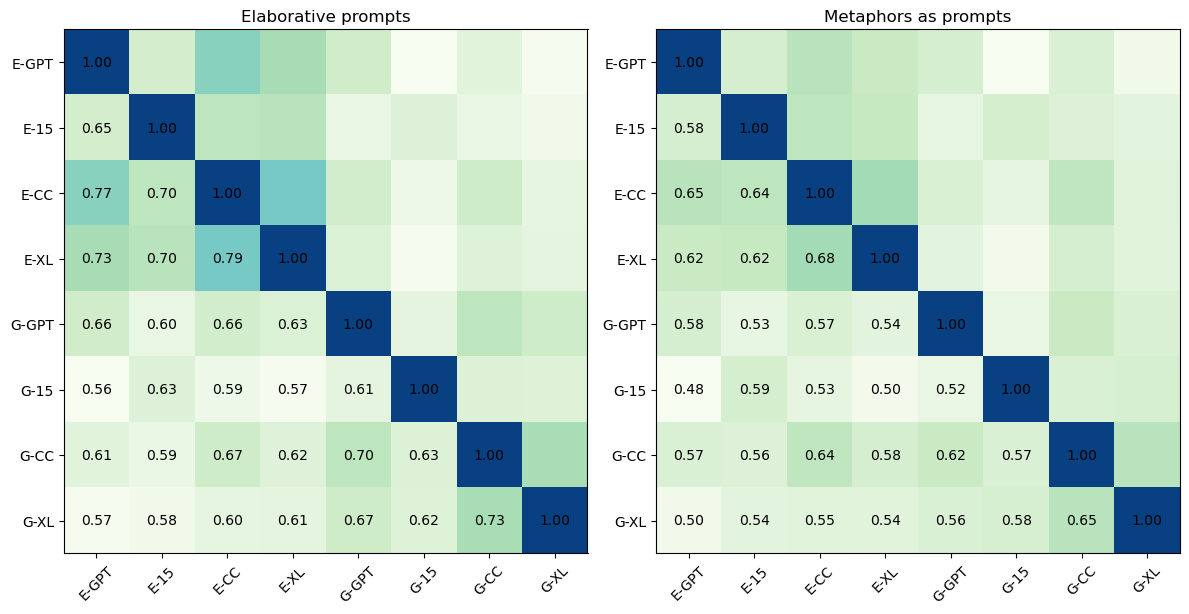

In [63]:
# Plot the similarity matrix as heatmap
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.imshow(similarity_matrix_long_prompts, cmap="GnBu", interpolation="nearest")
plt.title("Elaborative prompts")
plt.xticks(range(8), ["E-GPT", "E-15", "E-CC", "E-XL", "G-GPT", "G-15", "G-CC", "G-XL"], rotation=45)
plt.yticks(range(8), ["E-GPT", "E-15", "E-CC", "E-XL", "G-GPT", "G-15", "G-CC", "G-XL"])
masked_matrix = np.triu(np.ones_like(similarity_matrix_long_prompts, dtype=bool))
for i in range(masked_matrix.shape[0]):
    for j in range(masked_matrix.shape[1]):
        if i >= j:  # Only annotate the lower triangle
            plt.text(j, i, f"{similarity_matrix_long_prompts[i, j]:.2f}", ha="center", va="center", color="black")

plt.subplot(1, 2, 2)
plt.imshow(similarity_matrix_short_prompts, cmap="GnBu", interpolation="nearest")
plt.title("Metaphors as prompts")
plt.xticks(range(8), ["E-GPT", "E-15", "E-CC", "E-XL", "G-GPT", "G-15", "G-CC", "G-XL"], rotation=45)
plt.yticks(range(8), ["E-GPT", "E-15", "E-CC", "E-XL", "G-GPT", "G-15", "G-CC", "G-XL"])
masked_matrix = np.triu(np.ones_like(similarity_matrix_short_prompts, dtype=bool))
for i in range(masked_matrix.shape[0]):
    for j in range(masked_matrix.shape[1]):
        if i >= j:  # Only annotate the lower triangle
            plt.text(j, i, f"{similarity_matrix_short_prompts[i, j]:.2f}", ha="center", va="center", color="black")
plt.tight_layout()
# plt.suptitle("M-CLIP/XLM-Roberta-Large-Vit-L-14")
plt.savefig("./output/image_to_image_baseclip.png", dpi=300, bbox_inches="tight")
plt.show()

In [22]:
def display_images_side_by_side(img1, img2, resize_to=None):
    if resize_to is not None:
        img1 = img1.resize(resize_to)
        img2 = img2.resize(resize_to)

    # Create a new blank image with the appropriate size
    total_width = img1.width + img2.width
    max_height = max(img1.height, img2.height)
    new_img = Image.new('RGB', (total_width, max_height))

    # Paste the images into the new image
    new_img.paste(img1, (0, 0))
    new_img.paste(img2, (img1.width, 0))

    # Display the combined image
    display(new_img)

In [23]:
sentences = [
    "A horse running slowly through a field of flowers",
    "The car broke down on the highway, causing a significant delay",
    "A horse running slowly through a field of flowers",
    "Two women waiting at a bench next to a street",
    "The kitchen has a white door with a window",
    
]

sentences2 = [
    "A horse running quickly through a flower fields",
    "The vehicle malfunctioned on the freeway, resulting in a major holdup",
    "The home office space seems to be very cluttered",
    "Zwei Frauen warten auf einer Bank neben einer Straße",
    "Dies ist eine offene Schachtel mit vier Gurken",
]

with torch.no_grad():
    inputs1 = processor(text=sentences, return_tensors="pt", padding=True, truncation=True)
    inputs2 = processor(text=sentences2, return_tensors="pt", padding=True, truncation=True)
    inputs3 = processor(
        images = [
            Image.open("./images/20240715_004752_A cat chasing a mouse in a dark room..png"),
            Image.open("./images/A cat chasing a mouse in a dark room v2.png"),
            Image.open("./images/A horse running through a field of flowers.png"),
        ], 
        return_tensors="pt"
    )
    sample_text_embeddings = model.get_text_features(**inputs1)
    sample_text_embeddings2 = model.get_text_features(**inputs2)
    sample_image_embeddings = model.get_image_features(**inputs3)

In [24]:
print("Text-to-text")
print(F.cosine_similarity(sample_text_embeddings[0].view(1,-1),sample_text_embeddings2[0].view(1,-1)))
print(F.cosine_similarity(sample_text_embeddings[1].view(1,-1),sample_text_embeddings2[1].view(1,-1)))
print(F.cosine_similarity(sample_text_embeddings[2].view(1,-1),sample_text_embeddings2[2].view(1,-1)))
print(F.cosine_similarity(sample_text_embeddings[3].view(1,-1),sample_text_embeddings2[3].view(1,-1)))
print(F.cosine_similarity(sample_text_embeddings[4].view(1,-1),sample_text_embeddings2[4].view(1,-1)))
print("Image-to-image")
print(F.cosine_similarity(sample_image_embeddings[0].view(1,-1),sample_image_embeddings[1].view(1,-1)))
print(F.cosine_similarity(sample_image_embeddings[0].view(1,-1),sample_image_embeddings[2].view(1,-1)))
print("Text-to-image")
# print(F.cosine_similarity(sample_text_embeddings[0].view(1,-1),sample_image_embeddings[0].view(1,-1)))
# print(F.cosine_similarity(sample_text_embeddings[1].view(1,-1),sample_image_embeddings[0].view(1,-1)))
# print(F.cosine_similarity(sample_text_embeddings[2].view(1,-1),sample_image_embeddings[0].view(1,-1)))
# print(F.cosine_similarity(sample_text_embeddings[3].view(1,-1),sample_image_embeddings[0].view(1,-1)))

Text-to-text
tensor([0.9488])
tensor([0.9312])
tensor([0.4913])
tensor([0.4879])
tensor([0.7114])
Image-to-image
tensor([0.6870])
tensor([0.5312])
Text-to-image


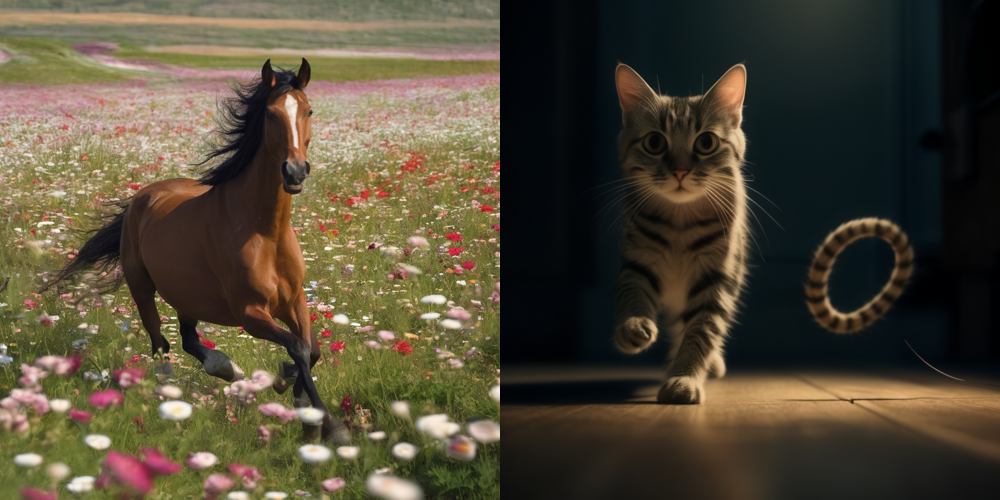

In [46]:
images = [
    Image.open(r"./images/20240715_004839_A horse running through a field of flowers..png"),
    Image.open(r"./images/A cat chasing a mouse in a dark room.png"),
]
images_2 = [
    Image.open(r"./images/A horse running through a field of flowers v2.png"),
    Image.open(r"./images/A cat chasing a mouse in a dark room v2.png"),    
]
texts = [
    "A horse running through a field of flowers.png",
    "A cat chasing a mouse in a dark room.png",    
]

inputs = processor(images=images, return_tensors="pt")
inputs2 = processor(images=images_2, return_tensors="pt")
inputs3 = processor(text=texts, return_tensors="pt", padding=True, truncation=True)
sample_image_embeddings = model.get_image_features(**inputs)
sample_image_embeddings_2 = model.get_image_features(**inputs2)
sample_text_embeddings = model.get_text_features(**inputs3)
display_images_side_by_side(images[0], images[1], (500,500))

In [26]:
F.cosine_similarity(sample_text_embeddings[0].view(1,-1), sample_image_embeddings[0].view(1,-1))

tensor([0.3294], grad_fn=<SumBackward1>)

In [47]:
print(F.cosine_similarity(sample_text_embeddings[0].view(1,-1),sample_text_embeddings[1].view(1,-1))) # text embedding similarity
print(F.cosine_similarity(sample_text_embeddings[0].view(1,-1),sample_image_embeddings[0].view(1,-1))) # text-image cross-modal similarity
print(F.cosine_similarity(sample_text_embeddings[0].view(1,-1), sample_image_embeddings[1].view(1,-1))) # text-image cross-modal similarity
print(F.cosine_similarity(sample_text_embeddings[1].view(1,-1), sample_image_embeddings[0].view(1,-1))) # text-image cross-modal similarity
print(F.cosine_similarity(sample_text_embeddings[1].view(1,-1), sample_image_embeddings[1].view(1,-1)))# text-image cross-modal similarity

tensor([0.6641], grad_fn=<SumBackward1>)
tensor([0.3922], grad_fn=<SumBackward1>)
tensor([0.1505], grad_fn=<SumBackward1>)
tensor([0.1879], grad_fn=<SumBackward1>)
tensor([0.3294], grad_fn=<SumBackward1>)


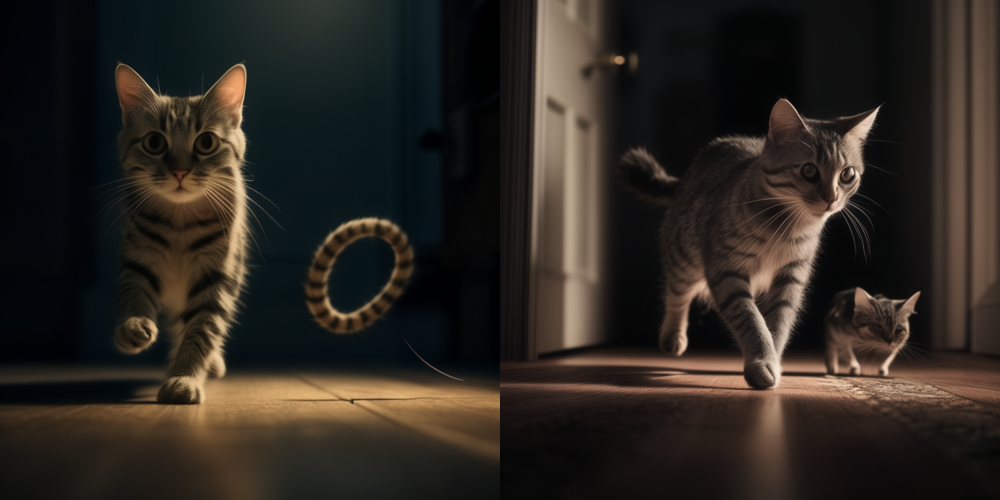

tensor([0.8854], grad_fn=<SumBackward1>)


In [28]:
display_images_side_by_side(images[0], images_2[0], (500,500))
print(F.cosine_similarity(sample_image_embeddings_2[0].view(1,-1), sample_image_embeddings[0].view(1,-1)))# text-image cross-modal similarity

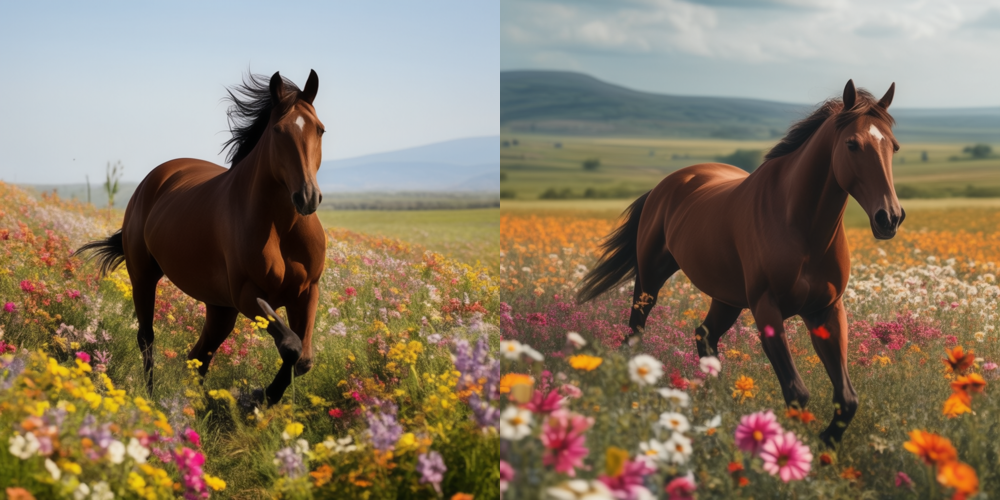

tensor([0.9451], grad_fn=<SumBackward1>)


In [29]:
display_images_side_by_side(images[1], images_2[1], (500,500))
print(F.cosine_similarity(sample_image_embeddings_2[1].view(1,-1), sample_image_embeddings[1].view(1,-1)))# text-image cross-modal similarity

In [30]:
baseline_text_embeddings = {}
baseline_text_embeddings["english"] = get_text_embeddings(r"./data/baseline_text.txt", model)
baseline_text_embeddings["german"] = get_text_embeddings(r"./data/baseline_text_german.txt", model)

In [31]:
baseline_image_embeddings = {
    "E-1.5": get_image_embeddings("/images/baseline/english/sd1.5/", model),
    "E-XL": get_image_embeddings("/images/baseline/english/sdxl/", model),
    "E-CC": get_image_embeddings("/images/baseline/english/sdcc/", model),
    "G-1.5": get_image_embeddings("/images/baseline/german/sd1.5/", model),
    "G-XL": get_image_embeddings("/images/baseline/german/sdxl/", model),
    "G-CC": get_image_embeddings("/images/baseline/german/sdcc/", model),
}

In [32]:
with open("./output/base_clip_baseline_text_embeddings.pickle", "wb") as file:
    pickle.dump(baseline_text_embeddings, file)
with open("./output/base_clip_baseline_image_embeddings.pickle", "wb") as file:
    pickle.dump(baseline_image_embeddings, file)

In [33]:
with open("./output/base_clip_baseline_text_embeddings.pickle", "rb") as file:
    baseline_text_embeddings = pickle.load(file)
with open("./output/base_clip_baseline_image_embeddings.pickle", "rb") as file:
    baseline_image_embeddings = pickle.load(file)

C:\Users\phanm\miniconda3\envs\ml\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [34]:
baseline_text_image_score = {
    "E-1.5": get_cosine_similarity(baseline_text_embeddings["english"], baseline_image_embeddings["E-1.5"]).mean().numpy(),
    "E-XL": get_cosine_similarity(baseline_text_embeddings["english"], baseline_image_embeddings["E-XL"]).mean().numpy(),
    "E-CC": get_cosine_similarity(baseline_text_embeddings["english"], baseline_image_embeddings["E-CC"]).mean().numpy(),
    "G-1.5": get_cosine_similarity(baseline_text_embeddings["german"], baseline_image_embeddings["G-1.5"]).mean().numpy(),
    "G-XL": get_cosine_similarity(baseline_text_embeddings["german"], baseline_image_embeddings["G-XL"]).mean().numpy(),
    "G-CC": get_cosine_similarity(baseline_text_embeddings["german"], baseline_image_embeddings["G-CC"]).mean().numpy(),    
}

In [64]:
rows = ["English", "German"]
columns = ["1.5", "XL", "CC"]

df_baseline = pd.DataFrame(index=rows, columns=columns)
df_baseline["GPT"] = [None, None]
for key, value in baseline_text_image_score.items():
    row, col = key.split("-")
    row = "English" if row == "E" else "German"
    df_baseline.at[row, col] = value
df_baseline = df_baseline.reindex(columns=["GPT", "1.5", "XL", "CC"])
df_baseline

,GPT,1.5,XL,CC
English,None,0.28786403,0.31767473,0.31267998
German,None,0.25282553,0.26434192,0.2662862


In [59]:
df_short = df_short.reindex(columns=["GPT", "1.5", "XL", "CC"])
df_short

,GPT,1.5,XL,CC
English,0.2749812,0.24144778,0.25872597,0.2540114
German,0.24481462,0.23713356,0.23105973,0.23098923


In [65]:
df_baseline["DataFrame"] = "Baseline"
df_long["DataFrame"] = "Long prompts"
df_short["DataFrame"] = "Short prompts"

In [67]:
final_df = pd.concat([df_baseline, df_long, df_short], keys=["Baseline", "Long prompts", "Short prompts"], names=["OpenAI Base Clip"]).drop(columns="DataFrame")
final_df

GPT         1.5          XL          CC
OpenAI Base Clip                                                        
Baseline         English        None  0.28786403  0.31767473  0.31267998
                 German         None  0.25282553  0.26434192   0.2662862
Long prompts     English   0.3139544  0.28107557   0.3178013  0.31023827
                 German   0.25405148  0.24312702   0.2515412  0.25986102
Short prompts    English   0.2749812  0.24144778  0.25872597   0.2540114
                 German   0.24481462  0.23713356  0.23105973  0.23098923

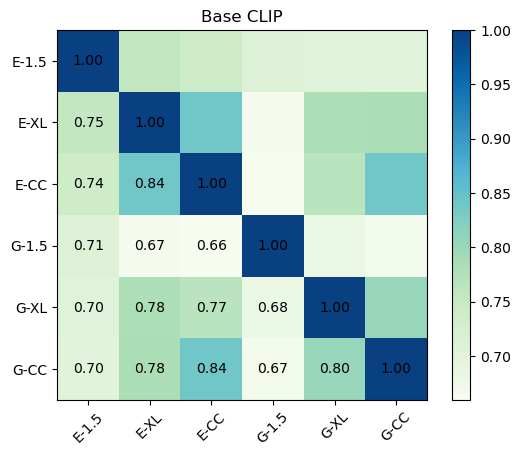

In [68]:
baseline_matrix = compute_cosine_similarity(list(baseline_image_embeddings.values()))
plt.imshow(baseline_matrix, cmap="GnBu", interpolation="nearest")
plt.colorbar(shrink=1)
plt.title("Base CLIP")
plt.xticks(range(6), list(baseline_image_embeddings.keys()), rotation=45)
plt.yticks(range(6), list(baseline_image_embeddings.keys()))
masked_matrix = np.triu(np.ones_like(baseline_matrix, dtype=bool))
for i in range(masked_matrix.shape[0]):
    for j in range(masked_matrix.shape[1]):
        if i >= j:  # Only annotate the lower triangle
            plt.text(j, i, f"{baseline_matrix[i, j]:.2f}", ha="center", va="center", color="black")
plt.savefig("./output/baseline_img_to_img_baseclip.png", dpi=300, bbox_inches="tight")

In [41]:
image_urls = [
    r"./images/20240715_004752_A cat chasing a mouse in a dark room..png",
    r"./images/A cat chasing a mouse in a dark room v2.png",    
]
image_series = [Image.open(image) for image in image_urls]
inputs = processor(images=image_series, return_tensors="pt")
with torch.no_grad():
    test_embeddings = model.get_image_features(**inputs)
F.cosine_similarity(test_embeddings[0].view(1,-1), test_embeddings[1].view(1,-1))

tensor([0.6870])

In [48]:
image_urls2 = [
    r"./images/20240715_004735_A horse running through a field of flowers..png",
    r"./images/20240718_002128_A bathroom with a toilet, sink, and shower.png",    
]
image_series2 = [Image.open(image) for image in image_urls2]
inputs = processor(images=image_series2, return_tensors="pt")
with torch.no_grad():
    test_embeddings2 = model.get_image_features(**inputs)
F.cosine_similarity(test_embeddings2[0].view(1,-1), test_embeddings2[1].view(1,-1))

tensor([0.5284])